In [1]:
""" Notebook looking at the merged sleep_position/o2 data
    Updates:
       Inferred ODI events before notebook
       Keep rows that were missing position measurements
       (Previously all rows had to be complete)
"""

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

sns.set(style="ticks")
sns.set_context(context="talk")


In [2]:
infile = "/Users/kmcmanus/Documents/classes/digitalhealth_project/data/formatted_data/20200628_sleep_pos_5S_cleaned.csv"
df = pd.read_csv(infile, index_col='datetime', parse_dates=True, infer_datetime_format=True)
df["sleep_night"] = pd.to_datetime(df["sleep_night"])
df = df[(~df["Orientation"].isna() | ~df["SpO2(%)"].isna())]
print("Total # rows: {}".format(df.shape[0]))
df.head()

Total # rows: 156424


,Orientation,Inclination,sleep_night,SpO2(%),Pulse Rate(bpm),Motion,Vibration,ODI,orient_bin,low_oxygen,hour,complete_hour,complete_night,time_since_pos_start
datetime,,,,,,,,,,,,,,
2020-04-21 20:58:55,-82.30,68.07,2020-04-21,96.0,66.0,0.0,0.0,NaN,1.0,0,20,0,1,1
2020-04-21 20:59:00,-81.72,68.09,2020-04-21,96.0,65.0,1.0,0.0,0.0,1.0,0,20,0,1,2
2020-04-21 20:59:05,-82.20,68.04,2020-04-21,96.0,64.0,1.0,0.0,0.0,1.0,0,20,0,1,3
2020-04-21 20:59:10,-76.71,71.69,2020-04-21,96.0,64.0,21.0,0.0,0.0,1.0,0,20,0,1,4
2020-04-21 20:59:15,-80.81,69.74,2020-04-21,96.0,64.0,18.0,0.0,0.0,1.0,0,20,0,1,5


In [3]:
df.describe()

,Orientation,Inclination,SpO2(%),Pulse Rate(bpm),Motion,Vibration,ODI,orient_bin,low_oxygen,hour,complete_hour,complete_night,time_since_pos_start
count,100827.000000,100827.000000,156424.000000,156424.000000,156424.000000,156424.000000,156411.000000,100827.000000,156424.000000,156424.000000,156424.000000,156424.000000,156424.000000
mean,-15.725180,92.354492,95.534912,62.027087,1.131246,0.085102,0.018739,0.138663,0.004462,9.291579,0.520125,0.975432,105.193359
std,73.536082,17.457866,1.842711,4.538416,7.261719,3.299377,0.135603,0.829362,0.066651,9.396579,0.499596,0.154804,154.062962
min,-179.630000,46.460000,71.000000,47.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-79.740000,76.740000,95.000000,59.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,2.000000,0.000000,1.000000,1.000000
50%,-14.530000,95.150000,96.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,39.000000
75%,65.350000,106.130000,97.000000,65.000000,0.000000,0.000000,0.000000,1.000000,0.000000,21.000000,1.000000,1.000000,150.000000
max,179.510000,178.910000,99.000000,96.000000,148.000000,128.000000,1.000000,1.000000,1.000000,23.000000,1.000000,1.000000,1115.000000


In [4]:
# How many days I have measurements for at least sleep position OR O2
dates = np.unique(df["sleep_night"])
dates = [pd.Timestamp(date) for date in dates]
print("Number of dates: {}".format(len(dates)))

Number of dates: 26


Text(0.5, 0, 'ODI (low oxygen) events')

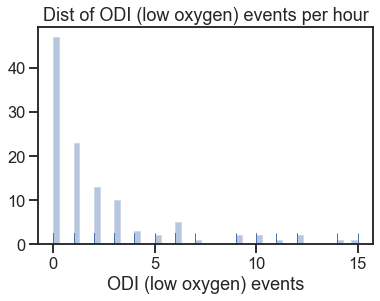

In [5]:
df_comp_hour = df[df["complete_hour"] == 1]
df_comp_hour.head()
# Counts number of times an ODI is entered
df_comp_hour["block"] = 0
#df_comp_hour["block"] = (
#                (df_comp_hour["ODI"] != df_comp_hour["ODI"].shift(1)) &
#                (df_comp_hour["ODI"] == 1)
#               ).astype(int).max()
df_comp_hour.loc[
    (df_comp_hour["ODI"] != df_comp_hour["ODI"].shift(1)) &
    (df_comp_hour["ODI"] == 1), "block"] = 1


df_low = df_comp_hour.groupby([df_comp_hour.index.date, df_comp_hour.index.hour]).sum()
ax = sns.distplot(df_low["block"], bins=45, kde=False, rug=True)
ax.set_title("Dist of ODI (low oxygen) events per hour")
ax.set_xlabel("ODI (low oxygen) events")
    

Text(0.5, 0, 'Number of low oxygen events (Only nights >= 5 hours)')

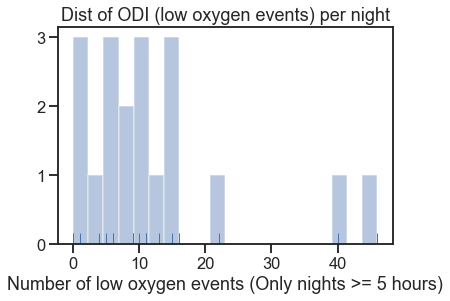

In [6]:
df_night = df_comp_hour[df_comp_hour["complete_night"] == 1]
df_night_to_plot = df_night.groupby("sleep_night")["block"].sum()

ax = sns.distplot(df_night_to_plot, bins=20, kde=False, rug=True)
ax.set_title("Dist of ODI (low oxygen events) per night")
ax.set_xlabel("Number of low oxygen events (Only nights >= 5 hours)")

In [7]:
df.columns

Index(['Orientation', 'Inclination', 'sleep_night', 'SpO2(%)',
       'Pulse Rate(bpm)', 'Motion', 'Vibration', 'ODI', 'orient_bin',
       'low_oxygen', 'hour', 'complete_hour', 'complete_night',
       'time_since_pos_start'],
      dtype='object')

In [8]:
# This doesn't take into account time edge cases
df["new_ODI"] = 0
df.loc[
    (df["ODI"] != df["ODI"].shift(1)) &
    (df["ODI"] == 1), "new_ODI"] = 1
df.columns

Index(['Orientation', 'Inclination', 'sleep_night', 'SpO2(%)',
       'Pulse Rate(bpm)', 'Motion', 'Vibration', 'ODI', 'orient_bin',
       'low_oxygen', 'hour', 'complete_hour', 'complete_night',
       'time_since_pos_start', 'new_ODI'],
      dtype='object')

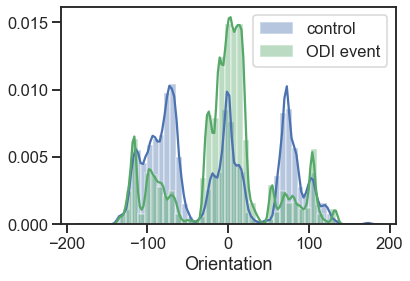

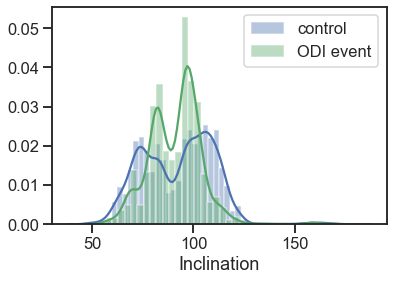

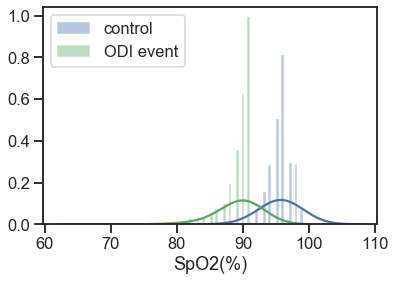

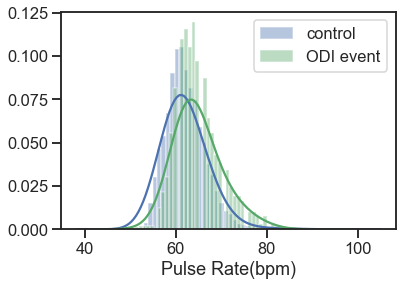

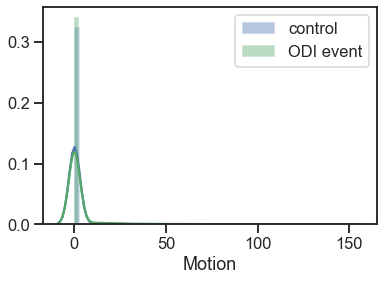

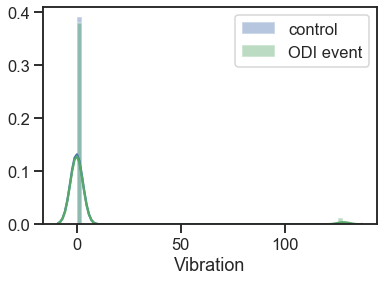

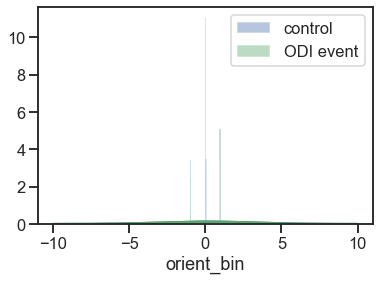

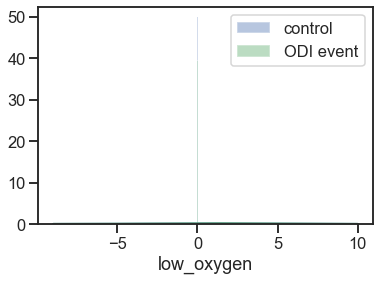

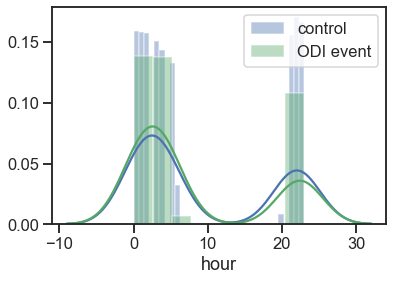

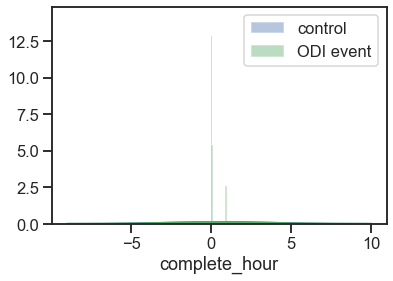

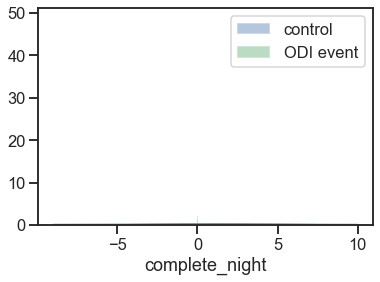

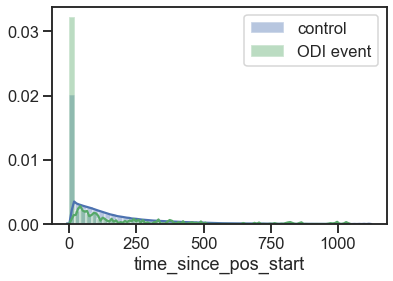

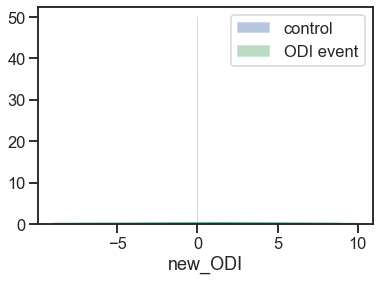

In [9]:
# Print feature distributions
features = df.columns

for feature in features:
    if feature == "sleep_night" or feature == "ODI":
        continue
    df_to_use = df[["ODI", feature]].dropna()
    
    fig, ax = plt.subplots()
    sns.distplot(df_to_use.loc[df_to_use["ODI"] == 0, feature],
                ax=ax, kde_kws={'bw': 3}, label="control")
    sns.distplot(df_to_use.loc[df_to_use["ODI"] == 1, feature],
                 ax=ax, color='g', kde_kws={'bw': 3}, label="ODI event")
    ax.legend()

datetime
2020-04-21 20:59:00    0_1
2020-04-21 20:59:05    0_1
2020-04-21 20:59:10    0_1
2020-04-21 20:59:15    0_1
2020-04-21 20:59:20    0_1
Name: ok, dtype: object


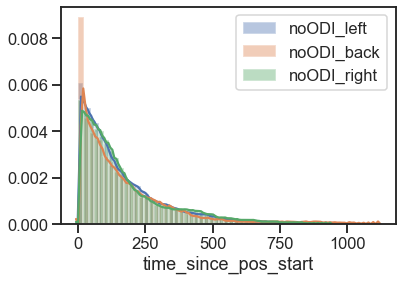

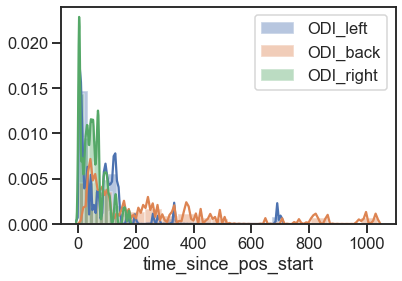

In [21]:

feature = "time_since_pos_start"

df_to_use = df[["ODI", "orient_bin", "time_since_pos_start"]].dropna()
df_to_use["ok"] = df_to_use["ODI"].astype(int).astype(str) + "_" + df_to_use["orient_bin"].astype(int).astype(str)
print(df_to_use["ok"].head())
    
fig, ax = plt.subplots()
sns.distplot(df_to_use.loc[df_to_use["ok"] == "0_1", feature],
            ax=ax, kde_kws={'bw': 3}, label="noODI_left")
sns.distplot(df_to_use.loc[df_to_use["ok"] == "0_0", feature],
            ax=ax, kde_kws={'bw': 3}, label="noODI_back")
sns.distplot(df_to_use.loc[df_to_use["ok"] == "0_-1", feature],
            ax=ax, kde_kws={'bw': 3}, label="noODI_right")
ax.legend()
fig, ax = plt.subplots()
sns.distplot(df_to_use.loc[df_to_use["ok"] == "1_1", feature],
            ax=ax, kde_kws={'bw': 3}, label="ODI_left")
sns.distplot(df_to_use.loc[df_to_use["ok"] == "1_0", feature],
            ax=ax, kde_kws={'bw': 3}, label="ODI_back")
sns.distplot(df_to_use.loc[df_to_use["ok"] == "1_-1", feature],
            ax=ax, kde_kws={'bw': 3}, label="ODI_right")
ax.legend()

In [10]:
feats = np.array(df.columns)


test = pd.get_dummies(df['orient_bin'], prefix='orient')
df = pd.concat([df, test], axis=1)
df.head()

,Orientation,Inclination,sleep_night,SpO2(%),Pulse Rate(bpm),Motion,Vibration,ODI,orient_bin,low_oxygen,hour,complete_hour,complete_night,time_since_pos_start,new_ODI,orient_-1.0,orient_0.0,orient_1.0
datetime,,,,,,,,,,,,,,,,,,
2020-04-21 20:58:55,-82.30,68.07,2020-04-21,96.0,66.0,0.0,0.0,NaN,1.0,0,20,0,1,1,0,0,0,1
2020-04-21 20:59:00,-81.72,68.09,2020-04-21,96.0,65.0,1.0,0.0,0.0,1.0,0,20,0,1,2,0,0,0,1
2020-04-21 20:59:05,-82.20,68.04,2020-04-21,96.0,64.0,1.0,0.0,0.0,1.0,0,20,0,1,3,0,0,0,1
2020-04-21 20:59:10,-76.71,71.69,2020-04-21,96.0,64.0,21.0,0.0,0.0,1.0,0,20,0,1,4,0,0,0,1
2020-04-21 20:59:15,-80.81,69.74,2020-04-21,96.0,64.0,18.0,0.0,0.0,1.0,0,20,0,1,5,0,0,0,1


In [11]:
# Logistic regression feature importance

# Everything except Orient_bin is significant lol.
# Try to make a graphical model out of this.

for i in np.array(df.columns):
    print(i)
    if i in ["sleep_night", "ODI", "orient_bin", "Orientation"]:
        continue
    df_to_use = df[["ODI", i]].dropna()
    x = preprocessing.scale(df_to_use[i]) # scaling features to mean 0, variance 1
    X = np.array(x).reshape(-1, 1) 
    logit_mod = sm.Logit(df_to_use["ODI"], X)
    result = logit_mod.fit(disp=0)
    print(result.summary())


Orientation
Inclination
                           Logit Regression Results                           
Dep. Variable:                    ODI   No. Observations:               100818
Model:                          Logit   Df Residuals:                   100817
Method:                           MLE   Df Model:                            0
Date:                Sun, 12 Jul 2020   Pseudo R-squ.:                  -9.958
Time:                        19:13:00   Log-Likelihood:                -69882.
converged:                       True   LL-Null:                       -6377.1
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0031      0.006     -0.492      0.623      -0.015       0.009
sleep_night
SpO2(%)
                           Logit Regression Results                           
Dep. Var

                           Logit Regression Results                           
Dep. Variable:                    ODI   No. Observations:               156411
Model:                          Logit   Df Residuals:                   156410
Method:                           MLE   Df Model:                            0
Date:                Sun, 12 Jul 2020   Pseudo R-squ.:                  -6.446
Time:                        19:13:05   Log-Likelihood:            -1.0841e+05
converged:                       True   LL-Null:                       -14560.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0076      0.005     -1.503      0.133      -0.018       0.002
time_since_pos_start
                           Logit Regression Results                           
Dep. Variable:                 

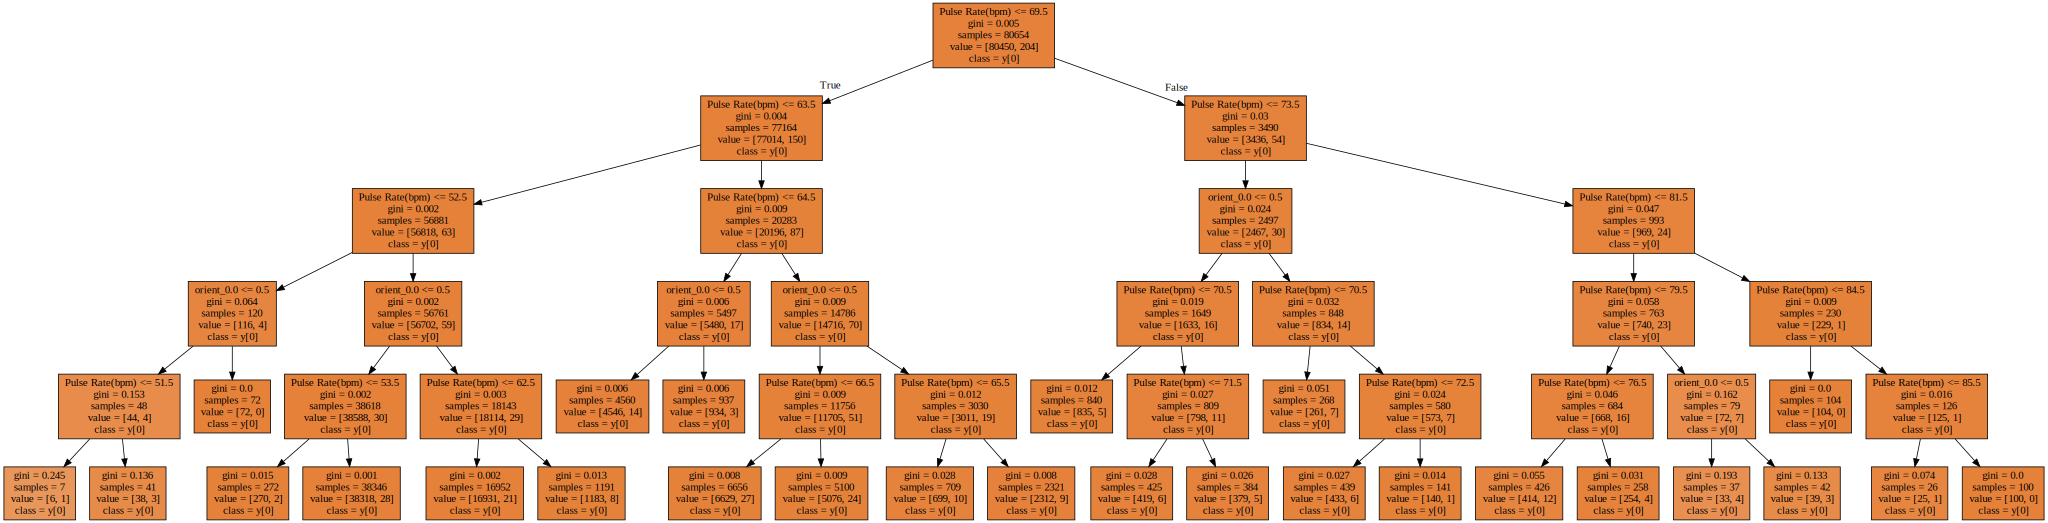

(array([0.99747068, 0.        ]), array([1., 0.]), array([0.99873374, 0.        ]), array([80450,   204]))
test
(array([0.99692521, 0.        ]), array([1., 0.]), array([0.99846024, 0.        ]), array([20102,    62]))
0    80654
dtype: int64
0    20164
dtype: int64


In [12]:
# Just try a random forest model to see how it works.
# It doesn't work well - low recall. Probably need to construct some better features.


from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

from IPython.display import SVG
from graphviz import Source
import graphviz
from IPython.display import display

df_nona = df.dropna()
#X = df_nona[['Inclination', 'Pulse Rate(bpm)', 'Motion',
#             'orient_-1.0', 'orient_0.0', 
#             'orient_1.0', 'hour', 'complete_hour', 'complete_night']] # Orientation, sleep_night
X = df_nona[['Pulse Rate(bpm)', 'orient_0.0']]
y = df_nona['low_oxygen']
#y = df_nona['ODI'] # or new_ODI or ODI or low_oxygen

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

clf = DecisionTreeClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf,out_file=None,
                                feature_names=['Pulse Rate(bpm)', 'orient_0.0'],
                                class_names=True,
                               filled=True)

display(graphviz.Source(dot_data))
#graph = graphviz.Source(dot_data)
#graph.render("image",view=True)


train_predict = clf.predict(X_train)
test_predict = clf.predict(X_test)

# returns: precision, recall, f_beta, support
result_train = precision_recall_fscore_support(y_train, train_predict) #, average='binary')
result_test = precision_recall_fscore_support(y_test, test_predict) #, average='binary')

print(result_train)
print("test")
print(result_test)

print(pd.Series(train_predict).value_counts())
print(pd.Series(test_predict).value_counts())

Feature ranking:
1. feature orient_0.0 (0.000000)
2. feature Pulse Rate(bpm) (0.000000)


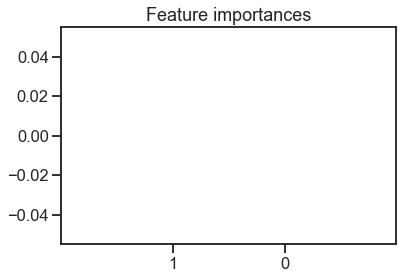

In [13]:
# Permutation feature importances
from sklearn.inspection import permutation_importance

importances = permutation_importance(clf, X_test, y_test, n_repeats=5, random_state=0)

mean_imp = importances.importances_mean
indices = np.argsort(mean_imp)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], mean_imp[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), mean_imp[indices],
        color="r", yerr=importances.importances_std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()